In [12]:
import pandas as pd
from pathlib import Path

PROC = Path('../data/processed')   # in your notebook cell

players  = pd.read_parquet(PROC/'players.parquet')
fixtures = pd.read_parquet(PROC/'fixtures.parquet')
history  = pd.read_parquet(PROC/'history.parquet')
teams    = pd.read_parquet(PROC/'teams.parquet')
positions= pd.read_parquet(PROC/'positions.parquet')

fixtures['utcDate']   = pd.to_datetime(fixtures['utcDate'])
fixtures['lastUpdated']= pd.to_datetime(fixtures['lastUpdated'])
score_df = pd.json_normalize(fixtures['score'])
fixtures = pd.concat([fixtures.drop(columns='score'), score_df], axis=1)
# 1. List out the columns you don’t need
cols_to_drop = [
    'squad_number',
    'penalties_order',
    'direct_freekicks_order',
    'corners_and_indirect_freekicks_order',
    'news_added',
    'chance_of_playing_this_round',
    'chance_of_playing_next_round',
    'birth_date',
    'team_join_date',
    'region'
]

# 2. Drop them (errors='ignore' skips any that aren’t present)
players = players.drop(columns=cols_to_drop, errors='ignore')

#print(players.columns[:10])

fixtures = fixtures.drop(columns=['odds','referees'], errors='ignore')

#print(players.shape, players.dtypes)
#print(fixtures.shape, fixtures.dtypes)

mv = players.isna().sum().sort_values(ascending=False).head(10)
#print(mv.head(10))

print(fixtures['id'].nunique(), history['element'].nunique())



380 801


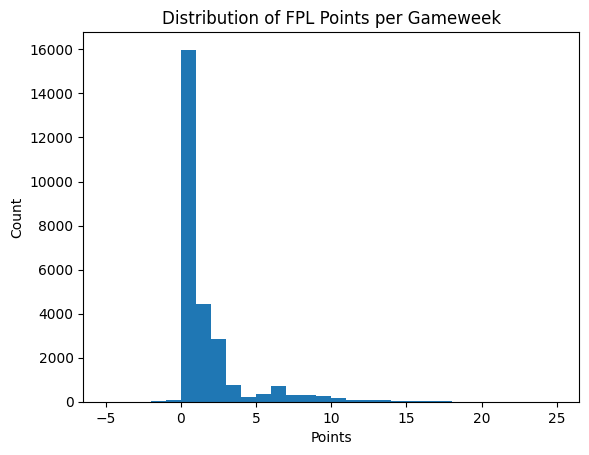

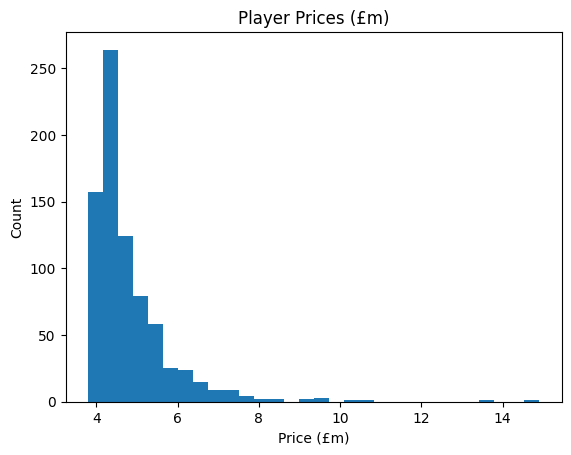

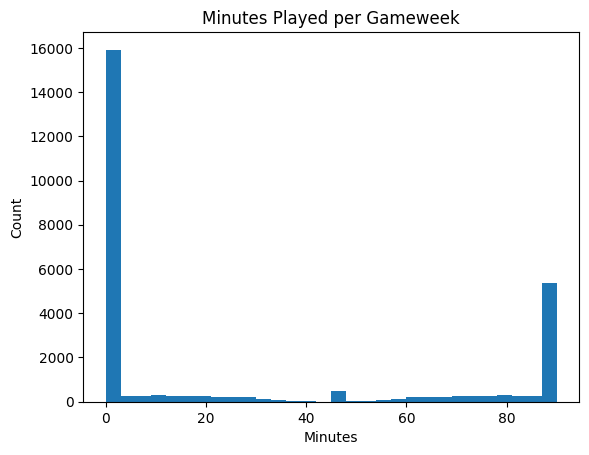

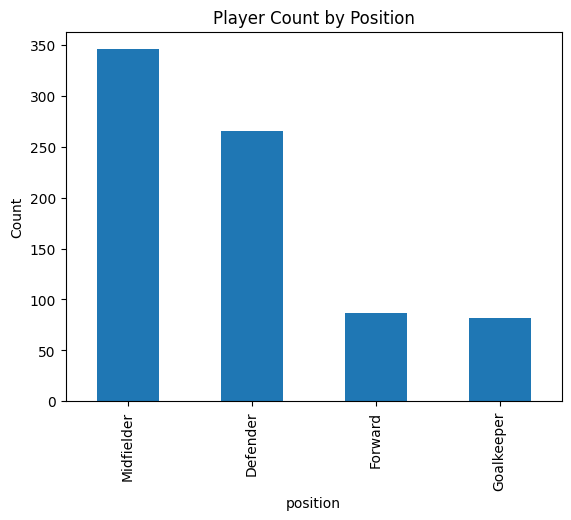

In [17]:
import matplotlib.pyplot as plt

# Reload full tables
players   = pd.read_parquet(PROC/'players.parquet')
history   = pd.read_parquet(PROC/'history.parquet')
positions = pd.read_parquet(PROC/'positions.parquet')

# Drop Manager rows once and for all
manager_id = positions.loc[positions['singular_name']=='Manager','id'].iloc[0]
players = players[players['element_type'] != manager_id]

# 1. Distribution of FPL points per Gameweek
plt.hist(history['total_points'], bins=30)
plt.title('Distribution of FPL Points per Gameweek')
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()

# 2. Distribution of player prices (£m)
# now_cost is in tenths of a million
plt.hist(players['now_cost'] / 10, bins=30)
plt.title('Player Prices (£m)')
plt.xlabel('Price (£m)')
plt.ylabel('Count')
plt.show()

# 3. Minutes played per Gameweek
plt.hist(history['minutes'], bins=30)
plt.title('Minutes Played per Gameweek')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.show()

# 4. Number of players by position
pos_map = positions.set_index('id')['singular_name'].to_dict()
# players.element_type holds the id
players['position'] = players['element_type'].map(pos_map)
# Keep only GK, DEF, MID, FWD
players = players[players['position'].isin(['Goalkeeper','Defender','Midfielder','Forward'])]
players['position'].value_counts().plot(kind='bar')
plt.title('Player Count by Position')
plt.ylabel('Count')
plt.show()


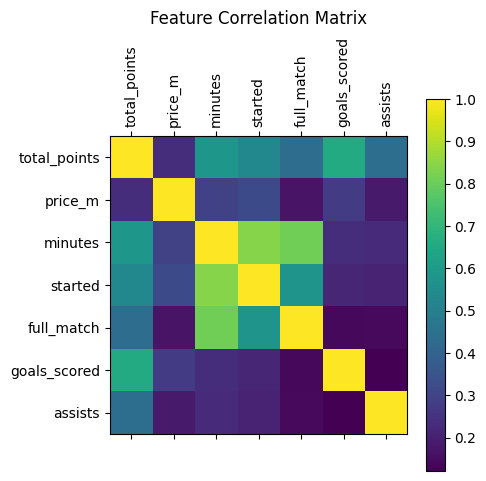

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load
PROC    = Path('../data/processed')
history = pd.read_parquet(PROC/'history.parquet')
players = pd.read_parquet(PROC/'players.parquet')

# Merge on player metadata
df = history.merge(
    players[['id','now_cost','element_type']],
    left_on='element', right_on='id', how='left'
)

# Derive simple features
df['price_m']    = df['now_cost'] / 10
df['started']    = (df['minutes'] > 0).astype(int)
df['full_match'] = (df['minutes'] == 90).astype(int)

# Select columns for correlation
corr_cols = [
    'total_points','price_m','minutes','started','full_match',
    'goals_scored','assists'
]
corr = df[corr_cols].corr()

# Plot heatmap
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Feature Correlation Matrix', y=1.35)
plt.show()

In [27]:
import pandas as pd
import json
from pathlib import Path
import pandas as pd

# Paths
RAW  = Path('../data/raw')
PROC = Path('../data/processed')

# 1. Load main tables
history = pd.read_parquet(PROC/'history.parquet')
players = pd.read_parquet(PROC/'players.parquet')

# 2. Load & normalize Understat JSON
with open(RAW/'understat-players-2025.json','r',encoding='utf8') as f:
    us = json.load(f)
understat = pd.json_normalize(us)[['player_name','xG','xA']]

# 3. Merge: history ← players ← understat
df = (
    history
    .merge(
        players[['id','web_name','now_cost','element_type']],
        left_on='element', right_on='id', how='left'
    )
    .merge(
        understat,
        left_on='web_name', right_on='player_name', how='left'
    )
)

# 4. Engineer simple features
df['price_m']    = df['now_cost'] / 10
df['started']    = (df['minutes'] > 0).astype(int)
df['full_match'] = (df['minutes'] == 90).astype(int)

# 5. Candidate columns
candidates = [
    'total_points','price_m','minutes','started','full_match',
    'goals_scored','assists',
    # advanced metrics (only if present)
    'influence','creativity','threat','ict_index','value_form','form',
    'xG','xA'
]

# 6. Filter to only those that exist in df
avail = [c for c in candidates if c in df.columns]
missing = set(candidates) - set(avail)
if missing:
    print("Warning: these features are not in the data and will be skipped:", missing)

# 7. Compute & print correlation matrix
corr = df[avail].corr()
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)        
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.width', 200)
print(corr)


              total_points  price_m  minutes  started  full_match  goals_scored  assists  influence  creativity  threat  ict_index    xG    xA
total_points          1.00     0.24     0.59     0.53        0.44          0.66     0.44       0.79        0.45    0.57       0.74  0.36  0.36
price_m               0.24     1.00     0.29     0.32        0.17          0.27     0.18       0.27        0.34    0.43       0.42  0.58  0.50
minutes               0.59     0.29     1.00     0.84        0.81          0.24     0.23       0.72        0.55    0.48       0.71  0.30  0.36
started               0.53     0.32     0.84     1.00        0.57          0.22     0.21       0.61        0.50    0.44       0.63  0.30  0.36
full_match            0.44     0.17     0.81     0.57        1.00          0.14     0.14       0.61        0.38    0.30       0.53  0.08  0.21
goals_scored          0.66     0.27     0.24     0.22        0.14          1.00     0.12       0.67        0.21    0.61       0.61  0.34  0.25